### Train

In [1]:
import json
import matplotlib.pyplot as plt

# Load training log JSON file
training_log_path = "/raid/decaro/TimeSeriesForecastingFoundationModels/chronos_output/chronos-bolt-mini/run-0/training_log.json"
with open(training_log_path, "r") as f:
    training_logs = json.load(f)

In [2]:
summary = training_logs[-2]
training_logs = training_logs[:-2]

In [3]:
# Pretty-print training summary
print("=== Final Training Summary ===")
print(f"Total training time:           {summary['train_runtime']:.2f} seconds")
print(f"Samples per second:            {summary['train_samples_per_second']:.2f}")
print(f"Steps per second:              {summary['train_steps_per_second']:.3f}")
print(f"Total FLOPs:                   {summary['total_flos']:.2e}")
print(f"Final training loss:           {summary['train_loss']:.4f}")

=== Final Training Summary ===


KeyError: 'train_runtime'

In [ ]:
# Find best model (based on minimum loss)
best_entry = min(training_logs, key=lambda x: x["loss"])
best_epoch = best_entry["epoch"]
best_loss = best_entry["loss"]

print("=== Best Model During Training ===")
print(f"Epoch:                         {best_epoch}")
print(f"Step:                          {int(best_epoch*200_000)}")
print(f"Loss:                          {best_loss:.4f}")

=== Best Model During Training ===
Epoch:                         0.35
Step:                          70000
Loss:                          2.8428


In [ ]:
# Extract metrics from the log
epochs = [entry["epoch"] for entry in training_logs]
steps = [entry["epoch"]*200_000 for entry in training_logs]
losses = [entry["loss"] for entry in training_logs]
grad_norms = [entry["grad_norm"] for entry in training_logs]
learning_rates = [entry["learning_rate"] for entry in training_logs]

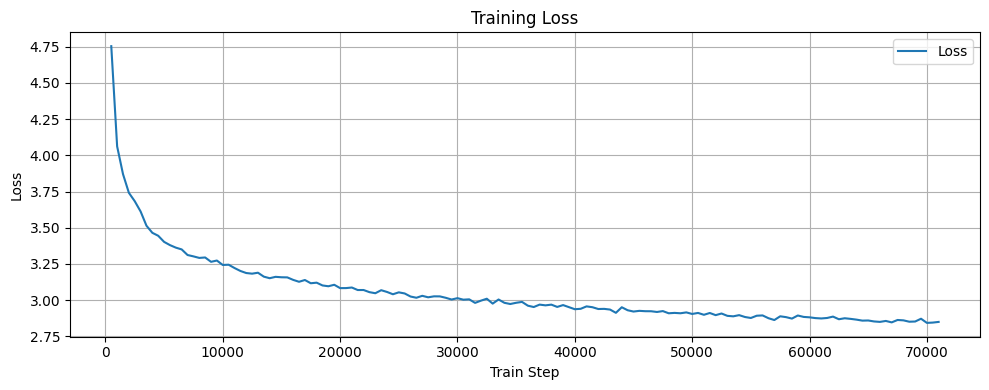

In [ ]:
# Plot: Loss vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, losses, label="Loss", color="tab:blue")
plt.xlabel("Train Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

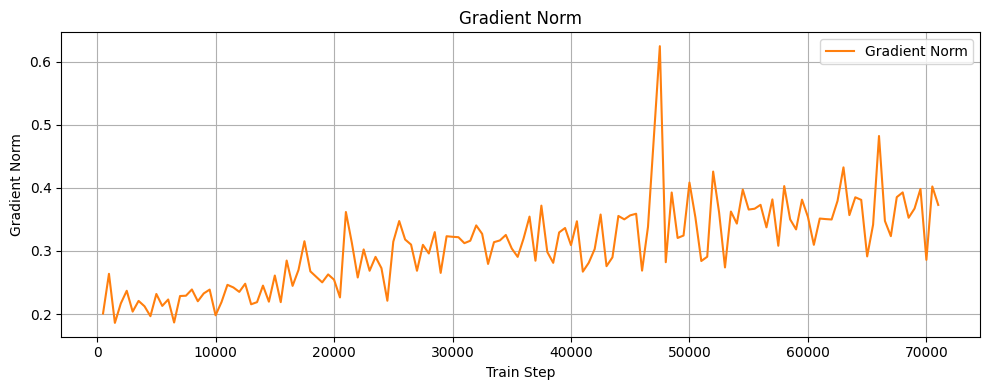

In [ ]:
# Plot: Gradient Norm vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, grad_norms, label="Gradient Norm", color="tab:orange")
plt.xlabel("Train Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

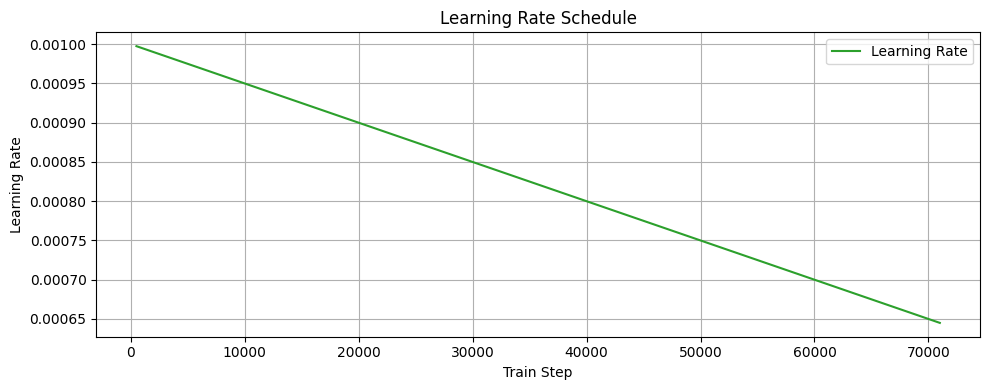

In [ ]:
# Plot: Learning Rate vs. Epoch
plt.figure(figsize=(10, 4))
plt.plot(steps, learning_rates, label="Learning Rate", color="tab:green")
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Test

In [ ]:
import pandas as pd

result_path = "results/test/chronos_bolt_mini_test_results.csv"

In [ ]:
df = pd.read_csv(result_path)
df = df[["dataset", "domain", "num_variates", "model", "train_step",
    "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
df = df.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
df = df.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})
df = df.rename(columns={"train_step": "train step"})

In [ ]:
df.head()

,dataset,domain,num_variates,model,train step,MASE,Qloss
0,exchange_rate/short,Econ/Fin,1,chronos-bolt-mini,40000,21.346106,0.060447
1,exchange_rate/medium,Econ/Fin,1,chronos-bolt-mini,40000,19.518960,0.060457
2,exchange_rate/long,Econ/Fin,1,chronos-bolt-mini,40000,19.836357,0.059275
3,ercot/short,Energy,1,chronos-bolt-mini,40000,2.419023,0.159599
4,ercot/medium,Energy,1,chronos-bolt-mini,40000,2.636137,0.164694


In [ ]:
def parse_dataset_string(s):
    parts = s.split('/')
    if len(parts) == 2:
        dataset = parts[0]
        freq = None
        term = parts[1]
    elif len(parts) == 3:
        dataset, freq, term = parts
    else:
        raise ValueError(f"Unexpected dataset format: {s}")
    return pd.Series([dataset, freq, term])

# Apply the parsing
df[['dataset_name', 'freq', 'term']] = df['dataset'].apply(parse_dataset_string)

# Manually fill missing frequencies
freq_map = {
    'exchange_rate': 'D',
    'ercot': 'H',
    'dominick': 'W'
}

df['freq'] = df.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
df.drop(columns='dataset', inplace=True)

df = df.rename(columns={"dataset_name": "dataset"})
df = df[["dataset", "freq", "term", "domain", "num_variates", "model", "train step",
    "MASE", "Qloss"]]


In [ ]:
df.head()

,dataset,freq,term,domain,num_variates,model,train step,MASE,Qloss
0,exchange_rate,D,short,Econ/Fin,1,chronos-bolt-mini,40000,21.346106,0.060447
1,exchange_rate,D,medium,Econ/Fin,1,chronos-bolt-mini,40000,19.518960,0.060457
2,exchange_rate,D,long,Econ/Fin,1,chronos-bolt-mini,40000,19.836357,0.059275
3,ercot,H,short,Energy,1,chronos-bolt-mini,40000,2.419023,0.159599
4,ercot,H,medium,Energy,1,chronos-bolt-mini,40000,2.636137,0.164694


In [ ]:
grouped_domain = df.groupby(['train step', 'domain'], as_index=False).mean(numeric_only=True)
grouped_domain = grouped_domain.sort_values(by=['train step', 'domain'])
grouped_domain

,train step,domain,num_variates,MASE,Qloss
0,40000,Econ/Fin,1.0,20.233808,0.060060
1,40000,Energy,1.0,2.606446,0.166028
2,40000,Sales,1.0,3.071723,0.704114
3,50000,Econ/Fin,1.0,20.178100,0.060721
4,50000,Energy,1.0,2.712720,0.171665
5,50000,Sales,1.0,3.081073,0.706918
6,60000,Econ/Fin,1.0,20.081200,0.060063
7,60000,Energy,1.0,2.714430,0.170723
8,60000,Sales,1.0,3.148829,0.712431
9,70000,Econ/Fin,1.0,19.870796,0.059490


In [ ]:
grouped_freq = df.groupby(['train step', 'freq'], as_index=False).mean(numeric_only=True)
grouped_freq = grouped_freq.sort_values(by=['train step', 'freq'])
grouped_freq

,train step,freq,num_variates,MASE,Qloss
0,40000,10S,1.0,7.874984,0.116346
1,40000,10T,1.0,1.769943,0.791813
2,40000,5T,1.0,2.140767,0.840412
3,40000,D,1.0,12.829449,0.167888
4,40000,H,1.0,2.329380,0.707047
5,40000,W,1.0,2.837800,0.920955
6,50000,10S,1.0,7.912511,0.116356
7,50000,10T,1.0,1.742892,0.774117
8,50000,5T,1.0,2.147208,0.845549
9,50000,D,1.0,12.805075,0.169472


In [ ]:
grouped_term = df.groupby(['train step', 'term'], as_index=False).mean(numeric_only=True)
grouped_term = grouped_term.sort_values(by=['train step', 'term'])
grouped_term

,train step,term,num_variates,MASE,Qloss
0,40000,long,1.0,4.386965,0.623172
1,40000,medium,1.0,4.477025,0.616817
2,40000,short,1.0,3.889686,0.628595
3,50000,long,1.0,4.440537,0.623493
4,50000,medium,1.0,4.563553,0.614364
5,50000,short,1.0,3.816671,0.637106
6,60000,long,1.0,4.418003,0.630752
7,60000,medium,1.0,4.528789,0.621597
8,60000,short,1.0,3.985228,0.638011
9,70000,long,1.0,8.560443,0.467803


In [ ]:
MODEL = "chronos_bolt_mini"
baseline_results = pd.read_csv(f"results/baseline_test/{MODEL}_results.csv")


chronos_benchmark = pd.read_csv("results/baseline_test/chronos_benchmark_results.csv")
chronos_benchmark = chronos_benchmark[chronos_benchmark["model"] == MODEL]

baseline_results = pd.concat([baseline_results, chronos_benchmark])

In [ ]:
baseline_results = baseline_results[["dataset", "domain", "num_variates", "model",
    "eval_metrics/MASE[0.5]", "eval_metrics/mean_weighted_sum_quantile_loss"]]
baseline_results = baseline_results.rename(columns={"eval_metrics/MASE[0.5]": "MASE"})
baseline_results = baseline_results.rename(columns={"eval_metrics/mean_weighted_sum_quantile_loss": "Qloss"})

baseline_results[['dataset_name', 'freq', 'term']] = baseline_results['dataset'].apply(parse_dataset_string)

baseline_results['freq'] = baseline_results.apply(lambda row: freq_map.get(row['dataset_name'], row['freq']), axis=1)
baseline_results.drop(columns='dataset', inplace=True)

baseline_results = baseline_results.rename(columns={"dataset_name": "dataset"})
baseline_results = baseline_results[["dataset", "freq", "term", "domain", "num_variates", "model",
    "MASE", "Qloss"]]

In [ ]:
baseline_results.head()

,dataset,freq,term,domain,num_variates,model,MASE,Qloss
0,bizitobs_service,10S,short,Web/CloudOps,2,chronos-bolt-mini,3.954530,0.065007
1,bizitobs_service,10S,medium,Web/CloudOps,2,chronos-bolt-mini,5.850413,0.118583
2,bizitobs_service,10S,long,Web/CloudOps,2,chronos-bolt-mini,6.522349,0.143846
3,solar,H,short,Energy,1,chronos-bolt-mini,0.860226,0.311360
4,solar,H,medium,Energy,1,chronos-bolt-mini,0.905875,0.352177


In [ ]:
baseline_term = baseline_results.groupby(['term'], as_index=False).mean(numeric_only=True)
baseline_domain = baseline_results.groupby(['domain'], as_index=False).mean(numeric_only=True)
baseline_freq = baseline_results.groupby(['freq'], as_index=False).mean(numeric_only=True)

In [ ]:
import matplotlib.pyplot as plt

def plot_metric_vs_train_step(grouped, baseline, group_col, metric_cols, title_prefix):
    """
    For each unique value in group_col (e.g. 'term', 'domain', 'freq'), plot the metric vs train step.
    
    Parameters:
        grouped: DataFrame with columns ['train step', group_col, ...metric_cols]
        baseline: DataFrame with columns [group_col, ...metric_cols]
        group_col: str, name of group column
        metric_cols: list of str, metric names (e.g. ['MASE', 'Qloss'])
        title_prefix: str, to prefix plot titles
    """
    unique_groups = sorted(grouped[group_col].unique())
    
    for metric in metric_cols:
        for group_value in unique_groups:
            # Filter Chronos results for this group values
            df_sub = grouped[grouped[group_col] == group_value]

            if df_sub.empty:
                continue  # Skip empty group
            
            # Get baseline value for this group (if available)
            baseline_value = baseline.loc[baseline[group_col] == group_value, metric]
            baseline_y = baseline_value.iloc[0] if not baseline_value.empty else None

            # Plot
            plt.figure(figsize=(6, 3))
            plt.plot(df_sub["train step"], df_sub[metric], marker='o', label="Finetuned")
            
            if baseline_y is not None:
                plt.axhline(y=baseline_y, color="black", linestyle="--", label="Baseline")

            plt.xlabel("Train step")
            plt.ylabel(metric)
            plt.title(f"{title_prefix}: {group_value}")
            #.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

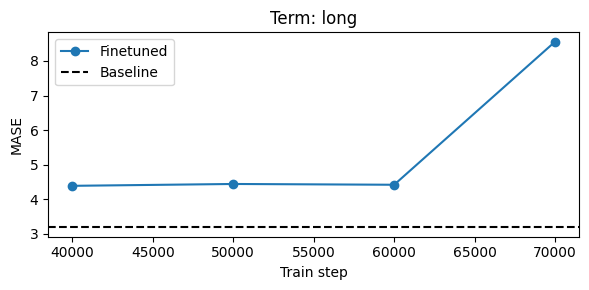

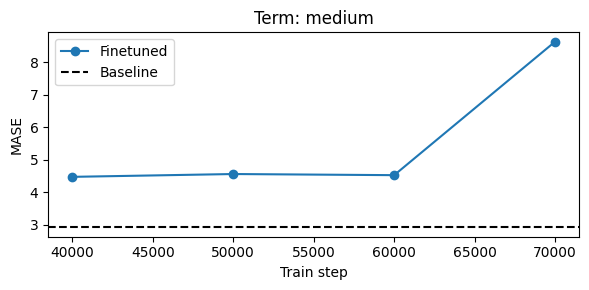

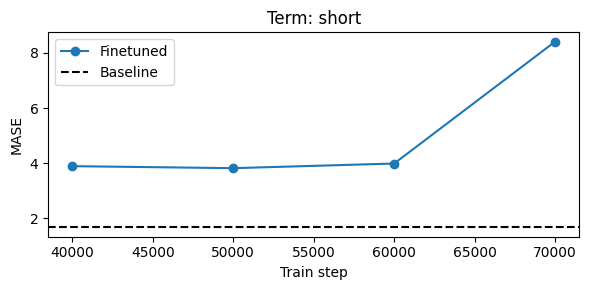

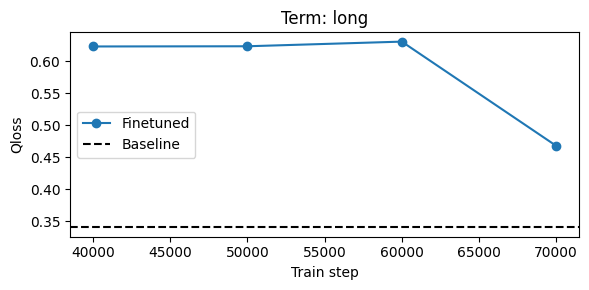

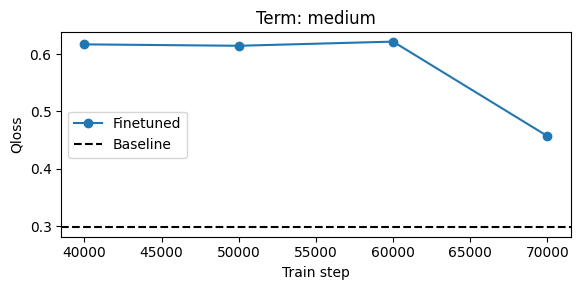

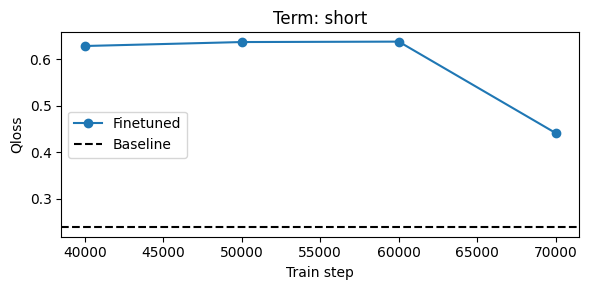

In [ ]:
# Plot: One plot for each TERM value (short, medium, long)
plot_metric_vs_train_step(grouped_term, baseline_term, group_col="term", metric_cols=["MASE", "Qloss"], title_prefix="Term")

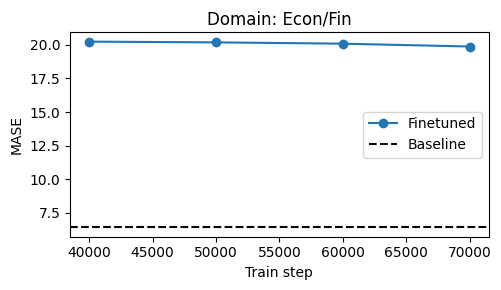

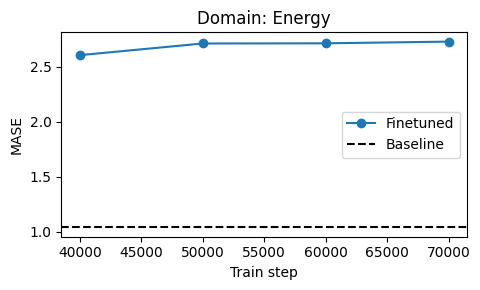

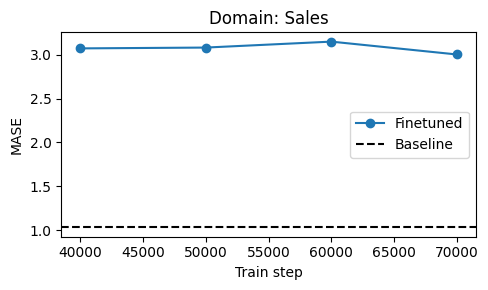

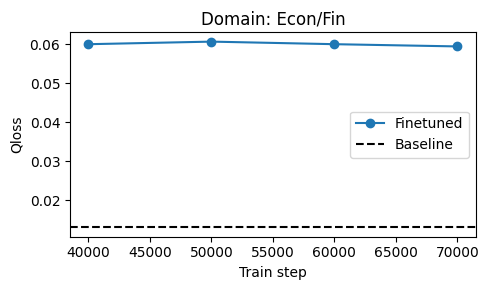

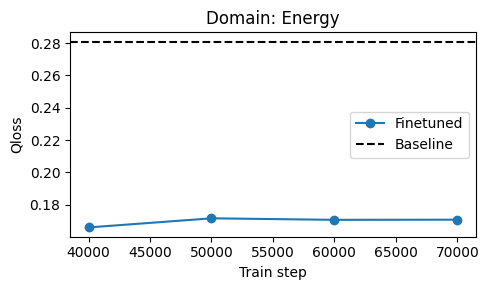

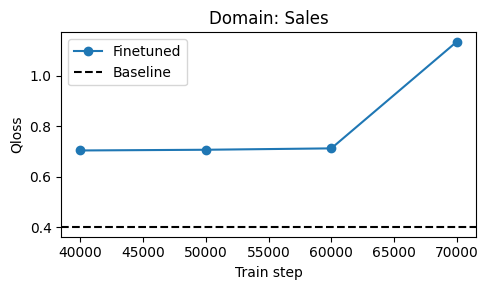

In [ ]:
# Plot: One plot for each DOMAIN value (Econ/Fin, Weather, ecc.)
plot_metric_vs_train_step(grouped_domain, baseline_domain, group_col="domain", metric_cols=["MASE", "Qloss"], title_prefix="Domain")

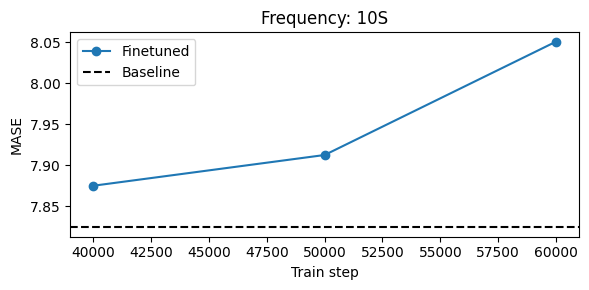

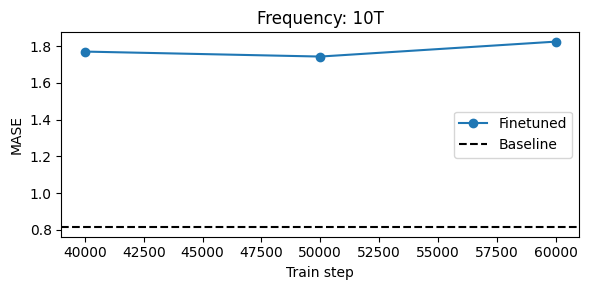

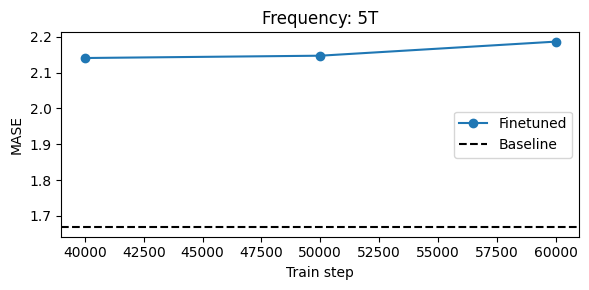

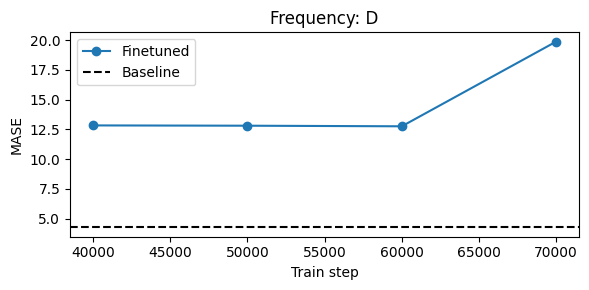

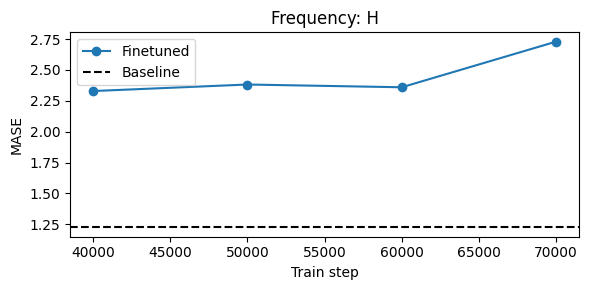

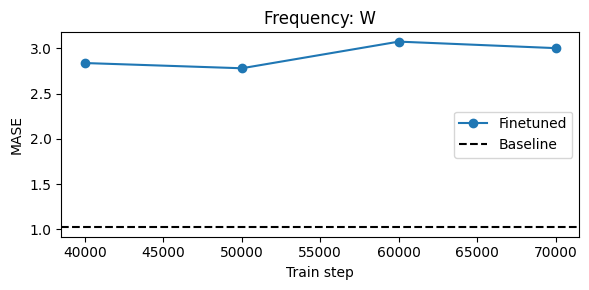

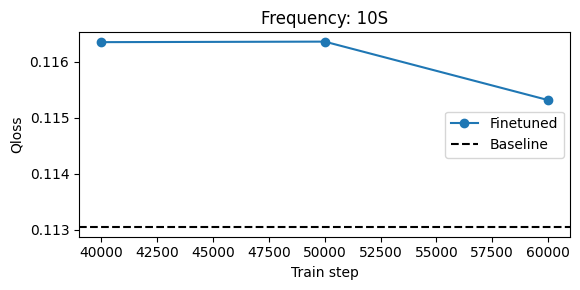

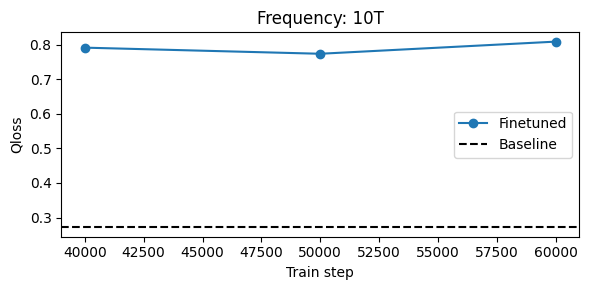

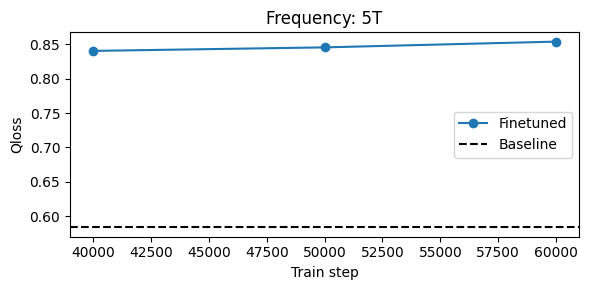

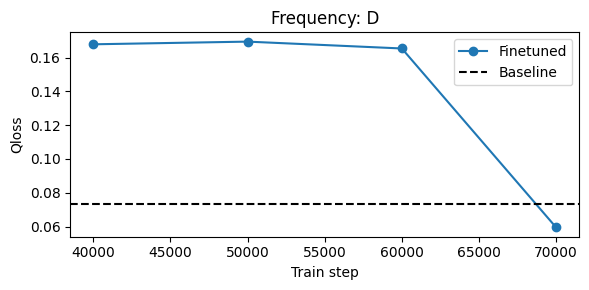

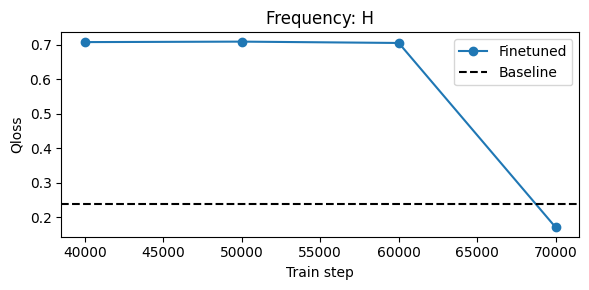

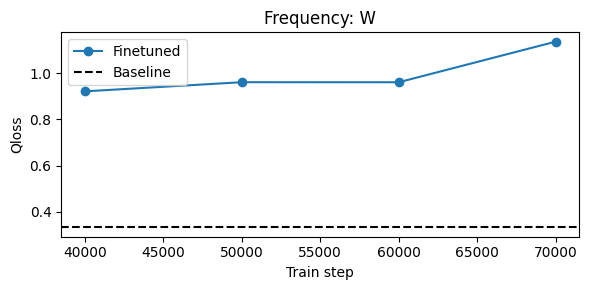

In [ ]:
# Plot: One plot for each FREQ value (D, H, 5T, ecc.)
plot_metric_vs_train_step(grouped_freq, baseline_freq, group_col="freq", metric_cols=["MASE", "Qloss"], title_prefix="Frequency")